# Мария Студеникина СТФИ-122
## Вариант 2

In [8]:
# Импорт библиотек для проведения расчетов
import pandas as pd
import numpy as np
# Импорт библиотек для построения и визуализации графов
import networkx as nx
import matplotlib.pyplot as plt

In [9]:
# Импорт пакетов для выполнения ассоциативных правил
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import association_rules
from mlxtend.frequent_patterns import fpgrowth

In [10]:
# Импорт пакетов для построения NMF, Self-Organizing Maps и ковариационной матрицы
from sklearn.decomposition import NMF
from sklearn_som.som import SOM
from sklearn.covariance import GraphicalLasso

In [11]:
from sklearn.datasets import load_iris
from scipy.sparse.csgraph import connected_components

In [12]:
# Загружаем данные из SAS файла
df = pd.read_csv("/home/ilumi/my/stud/analyse/assc_TRANSACTION.csv")
# Проверка
df.head()

,CUSTOMER,TIME,PRODUCT
0,0,0,hering
1,0,1,corned_b
2,0,2,olives
3,0,3,ham
4,0,4,turkey


In [13]:
# ПУНКТ 1 
# Определите сколько различных значений принимают переменные Product и Customer.

n_PRODUCT = len(pd.unique(df['PRODUCT']))
n_CUSTOMER = len(pd.unique(df['CUSTOMER']))
print("Количество уникальных значений PRODUCT = ", n_PRODUCT)
print("Количество уникальных значений CUSTOMER = ", n_CUSTOMER)


Количество уникальных значений PRODUCT =  20
Количество уникальных значений CUSTOMER =  1001


Функция Pandas unique() извлекает уникальные данные из набора данных. Метод unique() не принимает никаких параметров и возвращает пустой массив уникальных значений в этом конкретном столбце.

Функция len() возвращает длину (количество элементов) в объекте.

## Построение моделей ассоциативных правил

In [14]:
# Создадим список транзакций в формате [[1,4,5], [3,5,3], ....]
# Каждый элемент списка - список того, что купил клиент

transactions = df.groupby('CUSTOMER').aggregate({"PRODUCT":list}).values[:, 0]


pandas.DataFrame.groupby() группирует DataFrame с помощью картографа или серии столбцов.

pandas.DataFrame.agg() агрегирует с помощью одной или нескольких операций по указанной оси.

pandas.DataFrame.values возвращает только значения в DataFrame, метки осей будут удалены.

In [15]:
# Список покупок для первого клиента

transactions[0]

['hering', 'corned_b', 'olives', 'ham', 'turkey', 'bourbon', 'ice_crea']

In [16]:
# Пункт 2
# Найдите частые эпизоды с ограничением на размер правила равным 4,
# с использованием алгоритма FPTree, 2%.
# Построим модель fpgrowth

# кодирование транзакций
def get_frequent_items(transac):
    te = TransactionEncoder()
    te_ary = te.fit(transac).transform(transac)
    df = pd.DataFrame(te_ary, columns = te.columns_)
    return fpgrowth(df, min_support = 0.02, max_len = 4, use_colnames = True) # построение модели

frequent_itemsets = get_frequent_items(transactions)

Поиск частых наборов с FP-tree
1. Для каждого элемента найти его условный базовый набор
2. На основе условного базового набора построить новое условное FP-tree поддерево для каждого элемента, рассматривая каждый путь как отдельную транзакцию
3. Повторить процесс для элементов каждого вновь созданного условного FP-tree поддерева
4. До тех пор пока результирующее FP-tree не будет пусто или не будет содержать единственный путь
5. Единственный путь генерирует все комбинации подпутей, каждый из которых есть частый набор

TransactionEncoder() кодирует данные транзакций базы данных в виде списка списков Python в массив NumPy.

In [17]:
frequent_itemsets.head()

,support,itemsets
0,0.485514,(hering)
1,0.472527,(olives)
2,0.402597,(bourbon)
3,0.390609,(corned_b)
4,0.312687,(ice_crea)


In [18]:
# Пункт 3
# Найдите самый большой (где больше всего элементов) частый эпизод, 
# содержащий продукт baguette. Какая у него поддержка?

x1 = frequent_itemsets
rslt_df = x1.sort_values(by = 'itemsets', ascending = False)
rslt_df_2 = rslt_df[rslt_df['itemsets'].astype(str).str.contains('baguette')]
rslt_df_2.head()

,support,itemsets
525,0.027972,"(hering, soda, artichok, baguette)"
410,0.032967,"(cracker, hering, baguette, avocado)"
761,0.026973,"(peppers, chicken, baguette)"
395,0.033966,"(hering, soda, baguette, avocado)"
413,0.127872,"(hering, baguette, avocado)"


sort_values(by = 'itemsets', ascending = False) - сортирует по убыванию по колличеству продуктов в 'itemsets' 

##### Есть два самых больших частных эпизода, которые содержат baguette:
##### 1. artichok, hering, soda, baguette с поддержкой равной 0.027972
##### 2. cracker, hering, avocado, baguette с поддержкой равной 0.032967

In [19]:
# Пункт 4.1
# Постройте ассоциативные правила с порогом на достоверность 40%.

x = association_rules(frequent_itemsets, metric = "confidence", min_threshold = 0.4)
x['len1'], x['len2'] = x.antecedents.str.len(), x.consequents.str.len()
x = x[(x['len1'] == 1) & (x['len2'] == 1)].drop(columns = ['len1', 'len2'])
x.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(hering),(heineken),0.485514,0.599401,0.287712,0.592593,0.988642,-0.003305,0.983289
1,(heineken),(hering),0.599401,0.485514,0.287712,0.480000,0.988642,-0.003305,0.989395
2,(cracker),(hering),0.487512,0.485514,0.200799,0.411885,0.848348,-0.035895,0.874805
3,(hering),(cracker),0.485514,0.487512,0.200799,0.413580,0.848348,-0.035895,0.873926
7,(hering),(olives),0.485514,0.472527,0.255744,0.526749,1.114748,0.026325,1.114572


association_rules(frequent_itemsets, metric = "confidence", min_threshold = 0.4) - функция для создания ассоциативных правил из частых наборов элементов

Частые ассоциации "если-то" называются правилами ассоциации, которые состоят из предшествующего (if) и последующего (then).

metric - метрика (достоверность)

min_threshold - минимальный порог (40%)

In [20]:
# Пункт 4.2
# Найдите правило с максимальным лифтом, содержащем продукт baguette в левой части правила.

x.loc[x['antecedents'] == {'baguette'}].sort_values(['lift'], ascending = False).head(1)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
720,(baguette),(avocado),0.391608,0.362637,0.214785,0.548469,1.512446,0.072773,1.41156


Доступ к группе строк и столбцов по меткам или логовому массиву.

.loc[]в основном основан на метках, но также может использоваться с логическим массивом.

#### Дайте ему письменную словесную интерпретацию, укажите и объясните его числовые показатели: поддержку, достоверность и подъем.

##### Поддержка примерно 0.2. Это означает, что в такой части транзакций продукты baguette и avocado присутствуют вместе.

##### Достоверность правила baguette -> avocado (это вероятность увидеть следствие в транзакции, учитывая, что оно также содержит предшествующее) равна примерно 0.5. Метрика не является симметричной или направленной. Оно обозначает, что при покупке baguette с большой вероятностью купят также и avocado.

##### Значение лифта > 1 косвенно подтверждает значимость правила, поскольку говорит о положительной связи двух предметных наборов (условия и следствия правила). 

## Построение графа

In [21]:
# Пункт 5 
# Используя только двухместные правила постройте ориентированный граф, 
# где вершины элементы правила, их цвет (или размер) – поддержка элемента (item support), 
# дуги – импликации (ориентированы в направлении от условия к следствию), 
# веса дугu – достоверности.

G = nx.DiGraph()
for t in transactions:
    for i in range(len(t) - 1):
        G.add_edge(t[i], t[i + 1])

In [22]:
def some_func(x):
    x_new, = x
    return x_new

функция превращает (это) в это

In [23]:
size = x[['antecedents','antecedent support']].drop_duplicates(ignore_index = True)
size

,antecedents,antecedent support
0,(hering),0.485514
1,(heineken),0.599401
2,(cracker),0.487512
3,(olives),0.472527
4,(bourbon),0.402597
5,(corned_b),0.390609
6,(ice_crea),0.312687
7,(chicken),0.314685
8,(ham),0.304695
9,(turkey),0.282717


df.drop_duplicates возвращает DataFrame с удаленными повторяющимися строками. Индексы игнорируются.

In [24]:
size['antecedents'] = size['antecedents'].apply(some_func)
size = size.sort_values(by = 'antecedents')
size['antecedent support'] = size['antecedent support'].apply(lambda x: x * 1000)
size

,antecedents,antecedent support
17,apples,313.686314
14,artichok,304.695305
13,avocado,362.637363
11,baguette,391.608392
19,bordeaux,73.926074
4,bourbon,402.597403
7,chicken,314.685315
10,coke,295.704296
5,corned_b,390.609391
2,cracker,487.512488


Записывает в колонку 'antecedents' новыую колонку с помощью apply, которая преобразована функцией some_func

In [25]:
H = nx.DiGraph()
H.add_nodes_from(sorted(G.nodes(data = True)))
H.add_edges_from(G.edges(data = True))
H.nodes()

NodeView(('apples', 'artichok', 'avocado', 'baguette', 'bordeaux', 'bourbon', 'chicken', 'coke', 'corned_b', 'cracker', 'ham', 'heineken', 'hering', 'ice_crea', 'olives', 'peppers', 'sardines', 'soda', 'steak', 'turkey'))

371


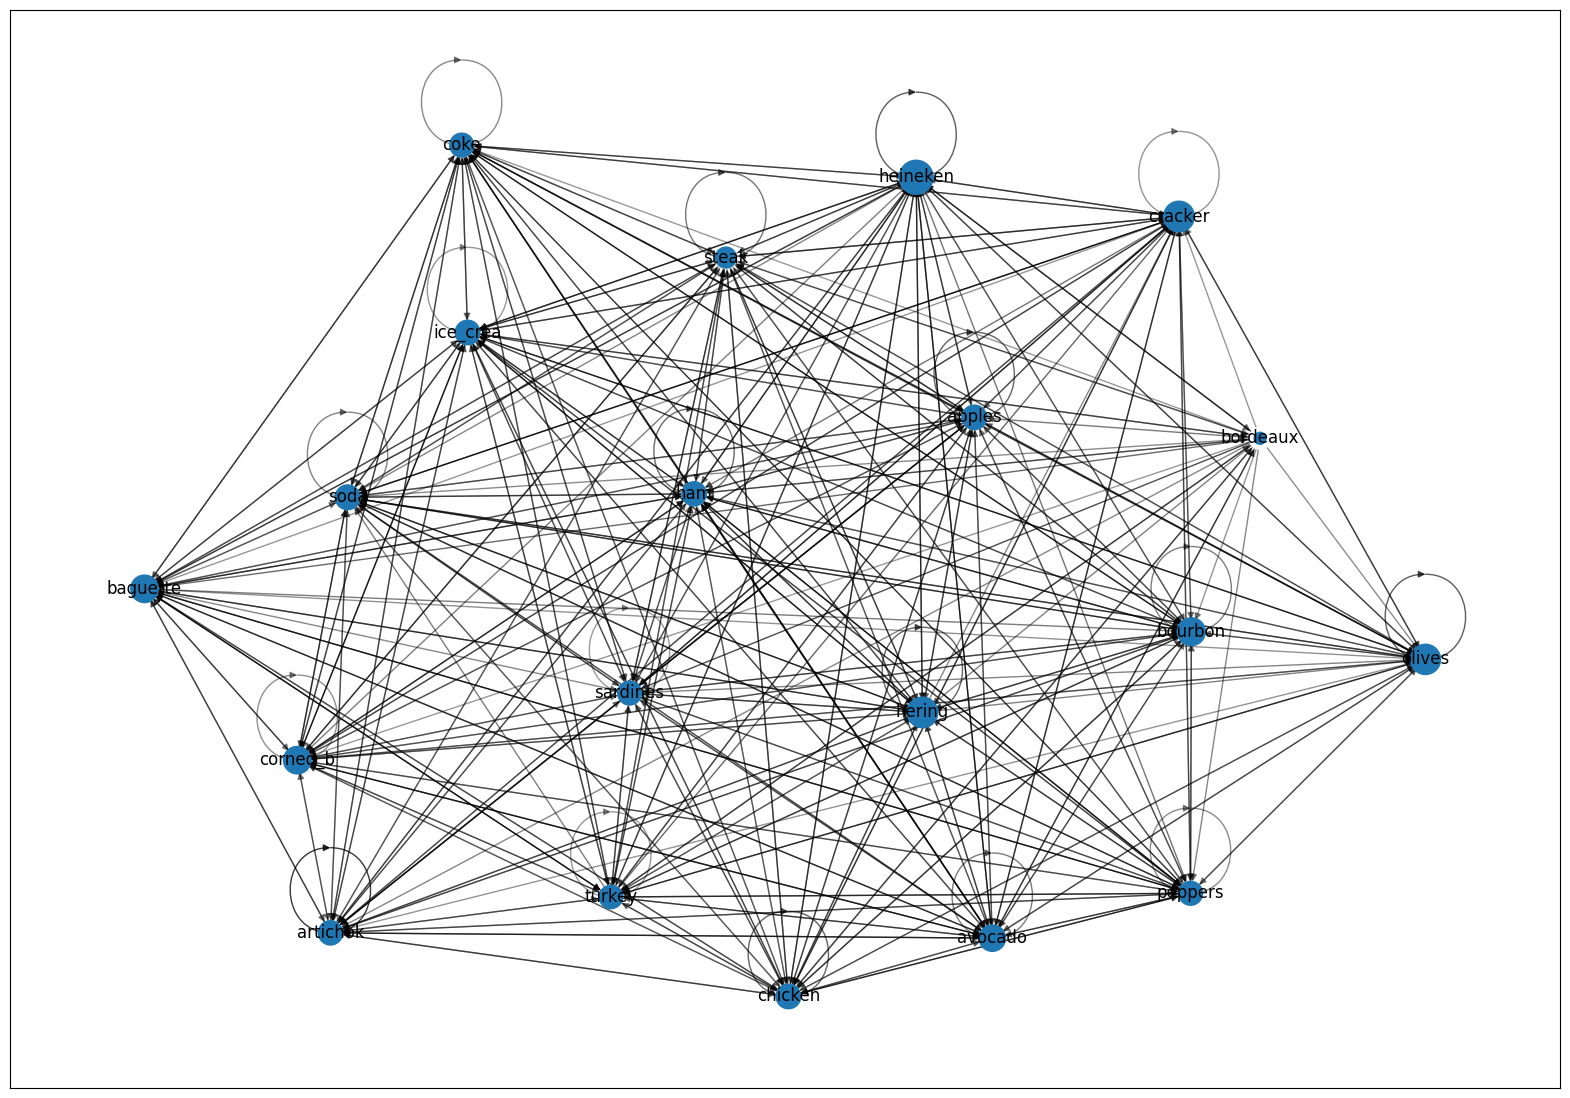

In [26]:
# Визуализируем граф
plt.figure(figsize = (20, 14))
pos = nx.spring_layout(H)
edges = nx.draw_networkx_edges(H, pos, alpha = x['confidence']) # дуги
nodes = nx.draw_networkx_nodes(H, pos, node_size = size['antecedent support']) # вершины
labels = nx.draw_networkx_labels(H, pos)
print(len(edges))

In [27]:
# Пункт 6
# Рассчитайте меры центральности closeness и найдите элемент с самой высокой мерой, 
# а также какую меру имеет baguette.

centr = nx.closeness_centrality(H)
closeness = pd.DataFrame.from_dict({
    'product': list(centr.keys()),
    'centrality': list(centr.values())
})
closeness = closeness.sort_values('centrality', ascending = False)
closeness

,product,centrality
0,apples,1.000000
7,coke,1.000000
18,steak,1.000000
17,soda,1.000000
13,ice_crea,1.000000
1,artichok,1.000000
8,corned_b,1.000000
10,ham,1.000000
6,chicken,1.000000
5,bourbon,1.000000


closeness_centrality(G) вычисляет центральность близости для узлов.

Центральности по близости — кратчайший путь от вершины i к вершине j, т. е. минимальное число ребер, через которые надо пройти, чтобы из вершины i попасть в вершину j.

Данная мера имеет простой физический смысл: чем меньше расстояния от i-ой вершины до остальных j-ых вершин графа (в экстремальном случае вершины i и j связаны 1 ребром), тем больше будет значение самой центральности.

pandas.DataFrame.from_dict создает объект DataFrame из словаря по столбцам или по индексу, позволяющим спецификацию dtype.

keys() - список всех ключей в словаре.

values() — это встроенная функция, которая возвращает список всех значений, доступных в данном словаре. 

In [28]:
closeness[closeness['centrality'] == 1]

,product,centrality
0,apples,1.0
7,coke,1.0
18,steak,1.0
17,soda,1.0
13,ice_crea,1.0
1,artichok,1.0
8,corned_b,1.0
10,ham,1.0
6,chicken,1.0
5,bourbon,1.0


In [29]:
closeness[closeness['product'] == 'baguette']

,product,centrality
3,baguette,0.863636


<BarContainer object of 20 artists>

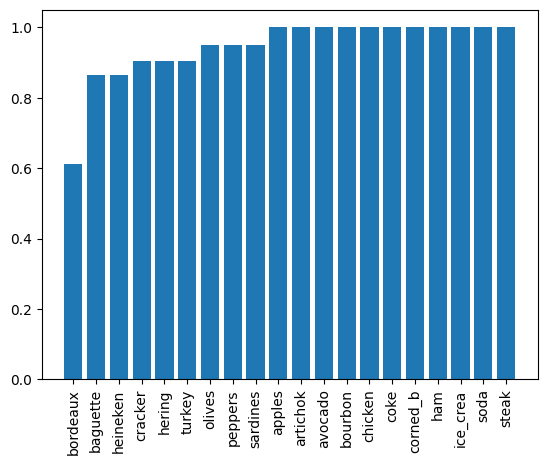

In [30]:
metr = dict(sorted(centr.items(), key = lambda x: x[1]))
plt.xticks(rotation = 'vertical')
plt.bar(metr.keys(), metr.values())

## Построение матрицы

In [31]:
# Пункт 7
# Постройте числовую матрицу со счетчиком числа покупок в ячейках, 
# клиентами по строкам и продуктами по столбцам.

matrix = df.groupby('CUSTOMER')['PRODUCT'].value_counts().unstack(fill_value = 0)
matrix

PRODUCT,apples,artichok,avocado,baguette,bordeaux,bourbon,chicken,coke,corned_b,cracker,ham,heineken,hering,ice_crea,olives,peppers,sardines,soda,steak,turkey
CUSTOMER,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,1,0,0,1,0,1,0,1,1,1,0,0,0,0,1
1,0,0,0,1,0,0,0,0,1,1,0,1,1,0,1,0,0,1,0,0
2,0,1,1,0,0,0,0,0,0,1,1,1,0,0,0,0,1,0,0,1
3,0,0,0,0,0,1,0,1,0,0,1,0,0,1,1,1,0,0,0,1
4,1,0,1,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
996,0,1,1,0,0,1,1,0,0,1,1,1,0,0,0,0,0,0,0,0
997,1,0,0,1,0,0,0,0,1,0,1,0,1,0,1,0,0,0,0,1
998,0,0,0,1,0,0,0,0,0,1,0,1,1,0,0,0,2,1,0,0


функция groupby() используется для разделения данных на группы на основе некоторых критериев.

Вы можете группировать по одному столбцу и подсчитать значения другого столбца по этому значению столбца с помощью value_counts. Используя groupby и value_counts, мы можем подсчитать количество [продуктов], которые совершил каждый (покупатель).

Мы также можем создать функции для подсчета количества продуктов на покупателя, применив unstuck. Unstack переключает строки в столбцы, чтобы продукты учитывалась как объекты. Выполняя unstuck, мы преобразуем последний уровень индекса в столбцы. Все значения продуктов теперь будут столбцами фрейма данных, и когда покупатель не купил какой-то продукт, эта функция получит значение NaN. fill_value = 0 заполняет все эти недостающие значения (продукты, которые не были куплены покупателями) значением 0.

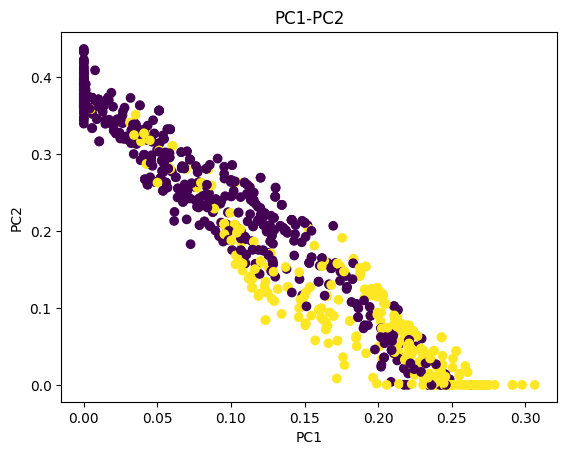

In [32]:
# Пункт 8
# С помощью метода NMF постройте линейную проекцию набора данных на плоскость 
# (2 компоненты) цветом укажите транзакции, содержащие baguette.

N = 2
nmf = NMF(n_components = N)
features = nmf.fit_transform(matrix)
plt.scatter(features[:, 0], features[:, 1], c = matrix['baguette'])
plt.title('PC1-PC2')
plt.xlabel('PC1')
plt.ylabel('PC2')
pass

iris = load_iris()
X = iris.data
Y = iris.target

N = 2
nmf = NMF(n_components = N)
features = nmf.fit_transform(X)
plt.scatter(features[:, 0], features[:, 1], c = Y)
plt.title('PC1-PC2')
plt.xlabel('PC1')
plt.ylabel('PC2')
pass

In [39]:
matrix.values

array([[0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 1, 0, 0],
       [0, 1, 1, ..., 0, 0, 1],
       ...,
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 1, 0]])

Text(0, 0.5, 'SOM dim 2')

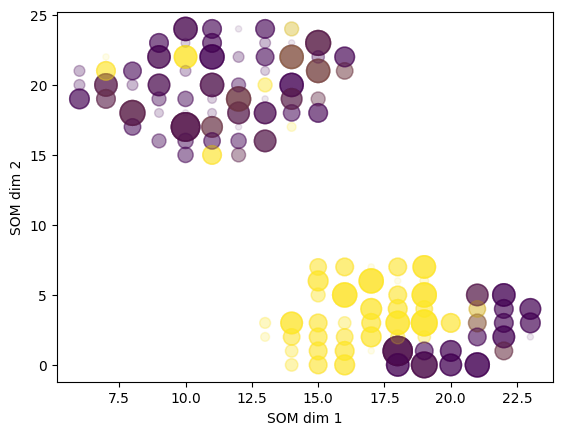

In [41]:
# Пункт 9
# С помощью метода SOM постройте нелинейную проекцию набора данных на плоскость цветом 
# укажите транзакции, содержащие продукт из вашего варианта.
# Дайте письменный комментарий, чем с вашей точки зрения для вашего примера 
# лучше или хуже нелинейная проекция.

X = matrix.values
Y = matrix['baguette']

N, M = 25, 25
som = SOM(m = M, n = N, dim = 20)
som.fit(X)
pred = som.predict(X)
#pred = SOM(m = M, n = N, dim = X.shape[-1]).fit_predict(X)
cnt = np.unique(pred, return_counts = True)
cnts = [dict(map(lambda i, j : (i, j), cnt[0], cnt[1]))[k] * 20 for k in pred]

xy = np.array([pred // N, pred % M, Y]).T

plt.scatter(xy[:, 0], xy[:, 1], c = Y, alpha = 0.1, s = cnts)
plt.xlabel('SOM dim 1')
plt.ylabel('SOM dim 2')


In [ ]:
# Пункт 10
# Из исходной матрицы (из пункта 7) отберите 3 независимых 
# переменных с использованием метода GLasso.

L = 0.001
RATE = 10
STEPS = 5
hierarchy = list()
step = dict()

for i in range(STEPS, 0, -1):
    cov_10 = GraphicalLasso(alpha = L * STEPS ** i, max_iter = 1000).fit(matrix)
    distance = cov_10.covariance_ > 0
    
    n, clusters = connected_components(distance, directed = False)
    
    for j in range(clusters.max() + 1):
        cluster = frozenset(matrix.columns[clusters == j])
        hierarchy.append(cluster)
        step[cluster] = STEPS - i

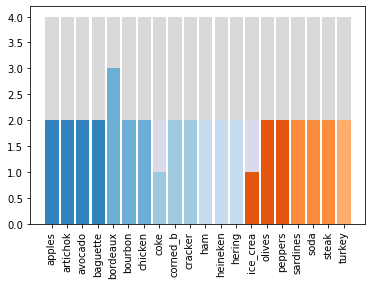

In [ ]:
plt.xticks(rotation = 'vertical')
cmap = plt.cm.tab20c(np.linspace(0, 1, len(hierarchy)))
for i, cluster in enumerate(hierarchy):
    x = list(cluster)
    y = np.ones(len(x)) * step[cluster]
    for bar in plt.bar(x, y, zorder = - i):
        bar.set_color(cmap[i])

In [ ]:
# Пункт 10
# Из исходной матрицы (из пункта 7) отберите 3 независимых 
# переменных с использованием метода GLasso.

cov = GraphicalLasso(alpha = 0.095).fit(matrix)
cov_1 = pd.DataFrame(columns = matrix.columns, index = matrix.columns, data = cov.covariance_)
cov_1

PRODUCT,apples,artichok,avocado,baguette,bordeaux,bourbon,chicken,coke,corned_b,cracker,ham,heineken,hering,ice_crea,olives,peppers,sardines,soda,steak,turkey
PRODUCT,,,,,,,,,,,,,,,,,,,,
apples,0.227114,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.00000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
artichok,0.000000,2.261495e-01,2.879144e-03,0.000000,0.000000,0.000000,0.000000,-2.689428e-10,-6.004731e-12,0.000000,0.000000,2.909676e-13,0.00000,-3.812587e-11,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
avocado,0.000000,2.879144e-03,2.402053e-01,0.000000,0.000000,0.000000,0.000000,-3.423953e-12,-7.644716e-14,0.000000,0.000000,3.704353e-15,0.00000,-4.853864e-13,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
baguette,0.000000,0.000000e+00,0.000000e+00,0.238251,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.00000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
bordeaux,0.000000,0.000000e+00,0.000000e+00,0.000000,0.068461,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.00000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
bourbon,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.260165,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.00000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
chicken,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.222754,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.00000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
coke,0.000000,-2.689428e-10,-3.423953e-12,0.000000,0.000000,0.000000,0.000000,2.130716e-01,1.384411e-09,0.000000,0.000000,-6.708354e-11,0.00000,3.020546e-02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
corned_b,0.000000,-6.004731e-12,-7.644716e-14,0.000000,0.000000,0.000000,0.000000,1.384411e-09,2.402493e-01,0.000000,0.000000,-1.164161e-02,0.00000,1.962568e-10,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [ ]:
# Пункт 10
# Из исходной матрицы (из пункта 7) отберите 3 независимых 
# переменных с использованием метода GLasso.

cov = GraphicalLasso(alpha = 0.01).fit(matrix)
cov_1 = pd.DataFrame(columns = matrix.columns, index = matrix.columns, data = cov.covariance_)
cov_1

PRODUCT,apples,artichok,avocado,baguette,bordeaux,bourbon,chicken,coke,corned_b,cracker,ham,heineken,hering,ice_crea,olives,peppers,sardines,soda,steak,turkey
PRODUCT,,,,,,,,,,,,,,,,,,,,
apples,0.227114,-0.021079,0.015019,0.018002,0.000000,-0.029258,-0.022309,-0.011946,0.025641,-0.056088,-0.033792,-0.071765,0.013480,-0.018313,0.006962,0.029161,0.023000,-0.031618,0.032430,-0.022111
artichok,-0.021079,0.226149,0.087879,0.024196,0.000000,-0.036957,-0.014775,-0.028545,-0.032747,0.015627,0.022585,0.055901,0.016376,-0.027761,-0.058820,-0.030099,-0.024551,-0.027072,-0.008615,-0.022824
avocado,0.015019,0.087879,0.240205,0.062205,0.000000,-0.064977,-0.049531,-0.053192,-0.049661,-0.001639,0.015418,0.036159,0.003089,-0.051527,-0.077431,0.008761,0.014242,-0.028917,-0.007874,-0.036810
baguette,0.018002,0.024196,0.062205,0.238251,0.000000,-0.050282,-0.035487,-0.038649,-0.052448,-0.002875,-0.054160,0.032111,0.047837,-0.040480,-0.074322,0.012321,0.015369,0.018551,-0.013787,-0.029960
bordeaux,0.000000,0.000000,0.000000,0.000000,0.068461,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
bourbon,-0.029258,-0.036957,-0.064977,-0.050282,0.000000,0.260165,0.024992,0.027112,0.003663,0.028284,-0.037310,-0.025741,-0.077767,0.027098,0.042032,0.026253,-0.034609,0.018077,-0.022514,0.014940
chicken,-0.022309,-0.014775,-0.049531,-0.035487,0.000000,0.024992,0.222754,0.035286,0.009449,0.011441,-0.024493,0.010301,-0.049968,0.031341,-0.059147,0.023725,0.030291,-0.024306,-0.017263,-0.033813
coke,-0.011946,-0.028545,-0.053192,-0.038649,0.000000,0.027112,0.035286,0.213072,-0.043645,-0.058805,-0.017367,0.001491,-0.064205,0.115205,0.016287,-0.022171,0.048227,-0.030926,-0.017528,0.023823
corned_b,0.025641,-0.032747,-0.049661,-0.052448,0.000000,0.003663,0.009449,-0.043645,0.240249,-0.013211,0.030735,-0.096643,0.043841,-0.045476,0.048320,0.019192,-0.039650,-0.043869,0.032147,0.031759


GraphicalLasso - оценка разреженной обратной ковариации (Раздельная оценка обратных ковариаций)

альфа-поплавок - параметр регуляризации: чем выше альфа, тем больше регуляризация, тем меньше обратная ковариация. Диапазон (0, inf].

fit(X[, y]) - подогнать модель GraphicalLasso на X.

covariance_ - расчетная ковариационная матрица

In [ ]:
print('Попарно независимые переменные')
# создадим новый фрейм состоящий из столбца с продуктами и столбца с перечислением продуктов, с которыми ковариация = 0
cov_2 = cov_1.apply(lambda row: row[row == 0].index, axis = 1)
for i in range(len(cov_2)):
    list = cov_2[i]
    list = str(list)
    start = (list.find('[')) + 2
    end = (list.find(']')) - 1
    if end - start < 20:
        list[start:end]
        print(list[start:end], '-', cov_2.index[i])

Попарно независимые переменные
bordeaux - apples
bordeaux - artichok
bordeaux - avocado
bordeaux - baguette
bordeaux - bourbon
bordeaux - chicken
bordeaux - coke
bordeaux - corned_b
bordeaux - cracker
bordeaux - ham
bordeaux - heineken
bordeaux - hering
bordeaux - ice_crea
bordeaux - olives
bordeaux - peppers
bordeaux - sardines
bordeaux - soda
bordeaux - steak
bordeaux - turkey
